Now creating a new script for filtering the ferrybox data and the wind/pos data for better alignment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path

In [111]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

In [112]:
# Create csv file to plot ferrybox data in qgis

# Select relevant columns (add/remove as needed)
df_qgis = df_all[[
    "Date", "Time", "Latitude", "Longitude"
]]

# Save to CSV
df_qgis.to_csv("df_combined_qgis.csv", index=False)


Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [3]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# # interpolate the gaps
# df_all = df_all.set_index('datetime')              # make time the index  
# df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
# df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [4]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Open the weather data to compute the Ekman bouyancy flux

In [6]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [8]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [9]:
df = df.rename(columns={'ts': 'Time'})
df = df.rename(columns={'longitude': 'Longitude'})
df = df.rename(columns={'latitude': 'Latitude'})

In [26]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df['datetime'] = pd.to_datetime(df['Time'])

df_all = df_all.sort_values('datetime')
df = df.sort_values('datetime')


In [14]:
from scipy.spatial import cKDTree
import numpy as np

# Create arrays of coordinates: (Latitude, Longitude) → convert to radians for distance
wind_coords = np.radians(df[['Latitude', 'Longitude']].to_numpy())
ferry_coords = np.radians(df_all[['Latitude', 'Longitude']].to_numpy())

# Build tree from wind positions
tree = cKDTree(wind_coords)

# Query nearest neighbor in wind data for each ferrybox point
dist_rad, idx = tree.query(ferry_coords, k=1)

# Convert radians to meters (~Earth radius)
earth_radius = 6371000  # meters
dist_m = dist_rad * earth_radius


In [15]:
# Create a new merged DataFrame
df_all_spatial = df_all.copy()

# Add columns from nearest wind row to each ferrybox row
nearest_wind = df.iloc[idx].reset_index(drop=True)
nearest_wind = nearest_wind.add_suffix('_wind')

df_all_spatial = pd.concat([df_all_spatial.reset_index(drop=True), nearest_wind], axis=1)
df_all_spatial['gps_spatial_offset_m'] = dist_m


In [18]:
# Ensure both columns are datetime
df_all_spatial['datetime'] = pd.to_datetime(df_all_spatial['datetime'])
df_all_spatial['Time_wind'] = pd.to_datetime(df_all_spatial['Time_wind'])

# Time difference in seconds
df_all_spatial['time_offset_s'] = (df_all_spatial['Time_wind'] - df_all_spatial['datetime']).dt.total_seconds()


In [49]:
df_filtered = df_all_spatial[np.abs(df_all_spatial['time_offset_s']) < 300].copy() # .copy ensures it's a true independent DataFrame
print(df_filtered.shape)
print(df_filtered['gps_spatial_offset_m'].describe())


(659, 43)
count    659.000000
mean     200.443837
std       85.995134
min        1.758146
25%      173.182829
50%      218.705270
75%      259.481809
max      332.863828
Name: gps_spatial_offset_m, dtype: float64


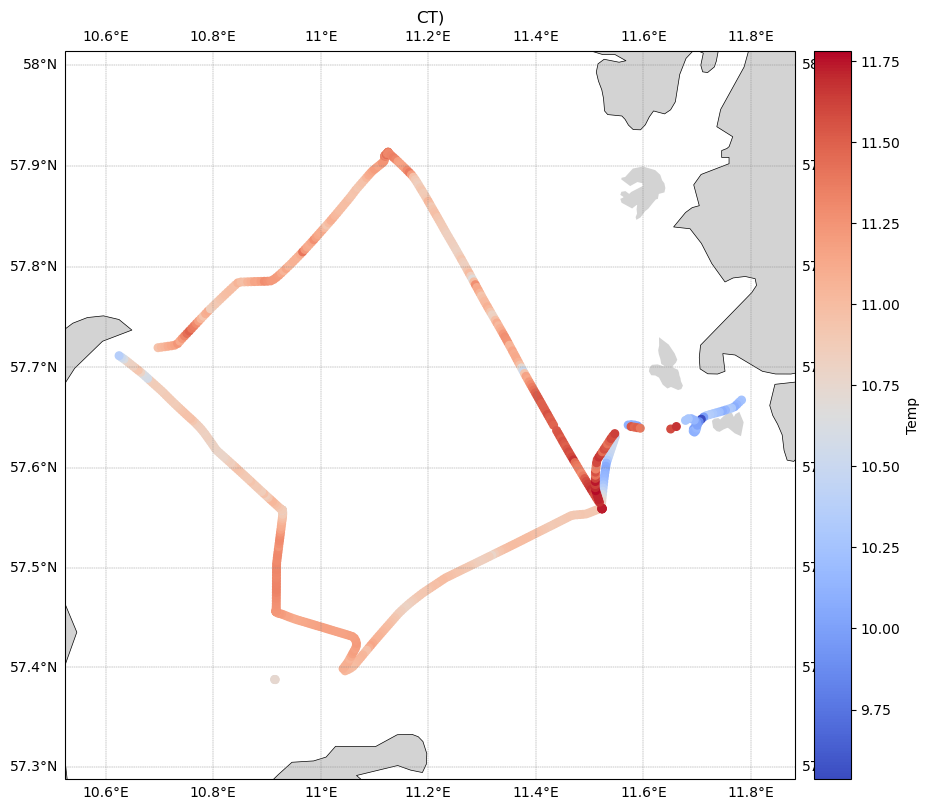

In [113]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_filtered['Longitude'], df_filtered['Latitude'],
                c=df_filtered['CT'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Temp')

ax.set_title('CT)')
plt.tight_layout()
plt.show()


Compute windstress

In [52]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_filtered['airtemp_wind'].to_numpy(float)         # °C
P   = df_filtered['airpressure_wind'].to_numpy(float) * 100    # hPa → Pa
RH  = df_filtered['humidity_wind'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_filtered['windspeed_wind'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df_filtered['winddir_wind'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_filtered['tau']   = tau
df_filtered['tau_x'] = tau_x
df_filtered['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_filtered[['Time', 'Latitude', 'Longitude', 'tau', 'tau_x', 'tau_y']].head())

       Time   Latitude  Longitude       tau     tau_x     tau_y
0  07:37:00  57.667360  11.782509  0.020442 -0.017144  0.011134
1  07:38:00  57.665152  11.778037  0.025695 -0.022688  0.012063
2  07:39:00  57.662873  11.773772  0.024328 -0.020169  0.013604
3  07:40:00  57.660707  11.769391  0.074482 -0.074380  0.003898
4  07:41:00  57.659370  11.764079  0.048819 -0.048077  0.008477


In [51]:
print(df_filtered.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0',
       'Time_wind', 'Latitude_wind', 'Longitude_wind', 'gndspeed_wind',
       'gndcourse_wind', 'gps_quality_wind', 'nbused_wind', 'hdop_wind',
       'airtemp_wind', 'humidity_wind', 'airpressure_wind', 'windspeed_wind',
       'winddir_wind', 'datetime_wind', 'gps_spatial_offset_m',
       'time_offset_s'],
      dtype='object')


Now I want to compute the Bouyancy gradient

In [53]:
# Option 1 of computing bouy grad

from pyproj import Geod
from scipy.interpolate import interp1d

g    = 9.81          # gravity (m s-2)
#rho0 = 1025.0        # reference density (kg m-3)
rho0 = np.nanmean(df_filtered['sigma0']+1000)

# distance along track (m)
geod = Geod(ellps="WGS84")
lon  = df_filtered["Longitude"].to_numpy()
lat  = df_filtered["Latitude"].to_numpy()
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))      # 0, 730 m, 1490 m, …

# buoyancy b = g (1 – ρ/ρ₀)  with ρ = σθ + 1000
rho = df_filtered["sigma0"].to_numpy() + 1000.0
b   = g * (1 - rho / rho0)

# regular 500 m distance grid
d_reg = np.arange(0, dist[-1], 1000.0)

# interpolate buoyancy onto this grid
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# constant-spacing gradient (Δx = 500 m)
dbdx_reg = np.gradient(b_reg, 500.0)          # s-2 on the regular grid

# map the regular-grid gradient back onto the original rows
df_filtered["buoy_grad"] = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)


In [103]:
# Method 2

import numpy as np
from pyproj import Geod
from scipy.interpolate import interp1d

# Constants
g = 9.81                 # gravity (m/s^2)
target_depth = 2.0       # target depth (meters)
depth_window = 0.5       # allowable depth variation (± meters)

# Step 1: Filter to measurements near the target depth
df_filtered['Depth'] = -gsw.z_from_p(df_filtered['pressure'] / 100, df_filtered['Latitude'])

depth = df_filtered["Depth"].to_numpy()
mask = np.abs(depth - target_depth) <= depth_window

# Only continue if we have enough points
if np.sum(mask) < 10:
    raise ValueError("Not enough points near the target depth for reliable gradient computation.")

# Subset data near the target depth
df_near_depth = df_filtered[mask].copy()
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()

# Step 2: Compute rho0 as mean density of filtered data
rho = sigma0 + 1000.0
rho0 = np.nanmean(rho)

# Step 3: Compute buoyancy
b = g * (1 - rho / rho0)

# Step 4: Compute cumulative distance along track
geod = Geod(ellps="WGS84")
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))  # distance in meters

# Step 5: Interpolate buoyancy to regular grid
dx = 1000.0
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# Step 6: Compute buoyancy gradient
dbdx_reg = np.gradient(b_reg, dx)  # units: 1/s²

# Step 7: Interpolate gradient back to original distances
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)

# Step 8: Store result
df_filtered["buoy_grad"] = buoy_grad


In [104]:
print(f"Depth range: {np.nanmin(depth):.2f} to {np.nanmax(depth):.2f} m")

Depth range: 1.80 to 2.21 m


In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(distance, buoyancy_grad, label=f'db/dx at {target_depth} m')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient at {target_depth} m Depth')
plt.legend()
plt.tight_layout()
plt.show()


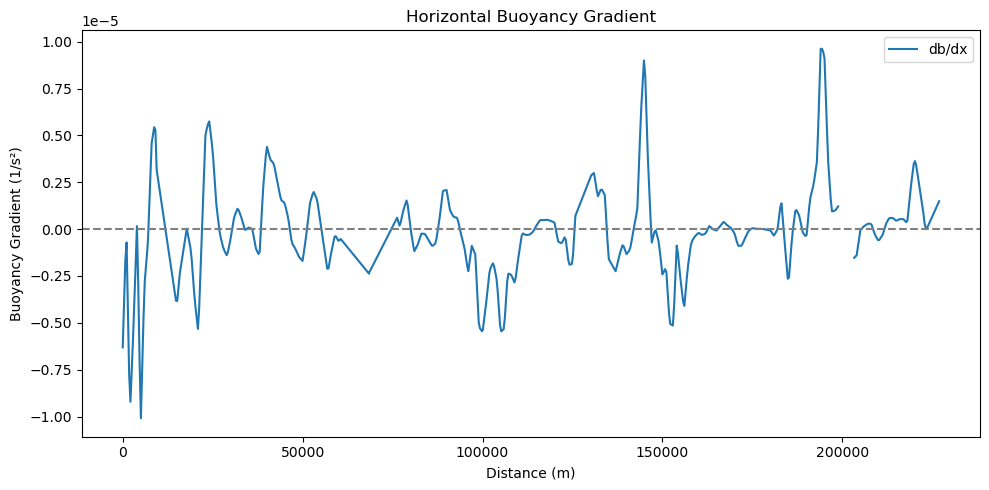

In [106]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, df_filtered['buoy_grad'], label=f'db/dx')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient')
plt.legend()
plt.tight_layout()
plt.show()

Compute corilois and then EBF

In [55]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [64]:
# prepare the two source tables
bx   = df_filtered[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      
tau  = df_filtered[['datetime','tau']]  # 

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')


# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
tau_const = 0.02

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (alpha * g))


In [78]:
# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
bx_const = 0.000000002
tau_const = 0.02

Q_EBF_const = -((bx_const * combo['tau']) / f) * (Cp / (alpha * g))

In [85]:
print(df_filtered['tau'].mean())
print(df_filtered['tau'].max())
print(df_filtered['tau'].min())
print(df_filtered['tau'].describe())
print(df_filtered['windspeed_wind'].describe())

0.09855560350921957
0.4676521741159301
0.0
count    659.000000
mean       0.098556
std        0.099534
min        0.000000
25%        0.012675
50%        0.079318
75%        0.129302
max        0.467652
Name: tau, dtype: float64
count    659.000000
mean       6.186039
std        3.781126
min        0.000000
25%        2.600000
50%        6.500000
75%        8.300000
max       15.800000
Name: windspeed_wind, dtype: float64


In [79]:
Q_EBF = -((df_filtered["buoy_grad"] * df_filtered['tau']) / (f)) * ((Cp) / (alpha *g))

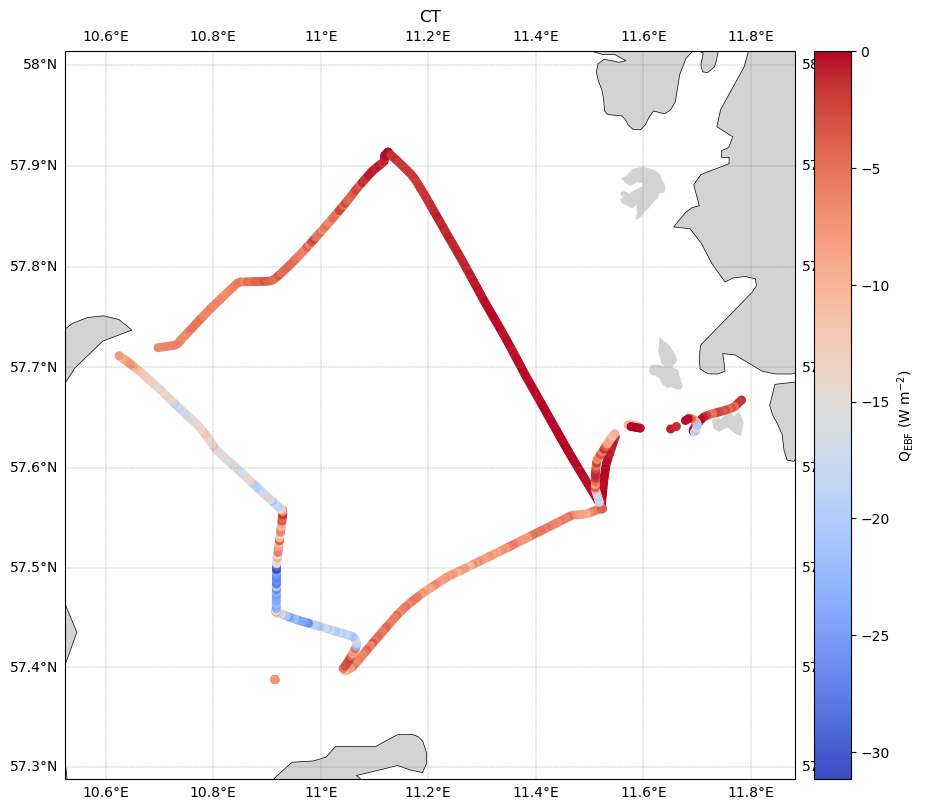

In [80]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_time_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_time_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_filtered['Longitude'], df_time_filtered['Latitude'],
                c=Q_EBF_const, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('CT')
plt.tight_layout()
plt.show()


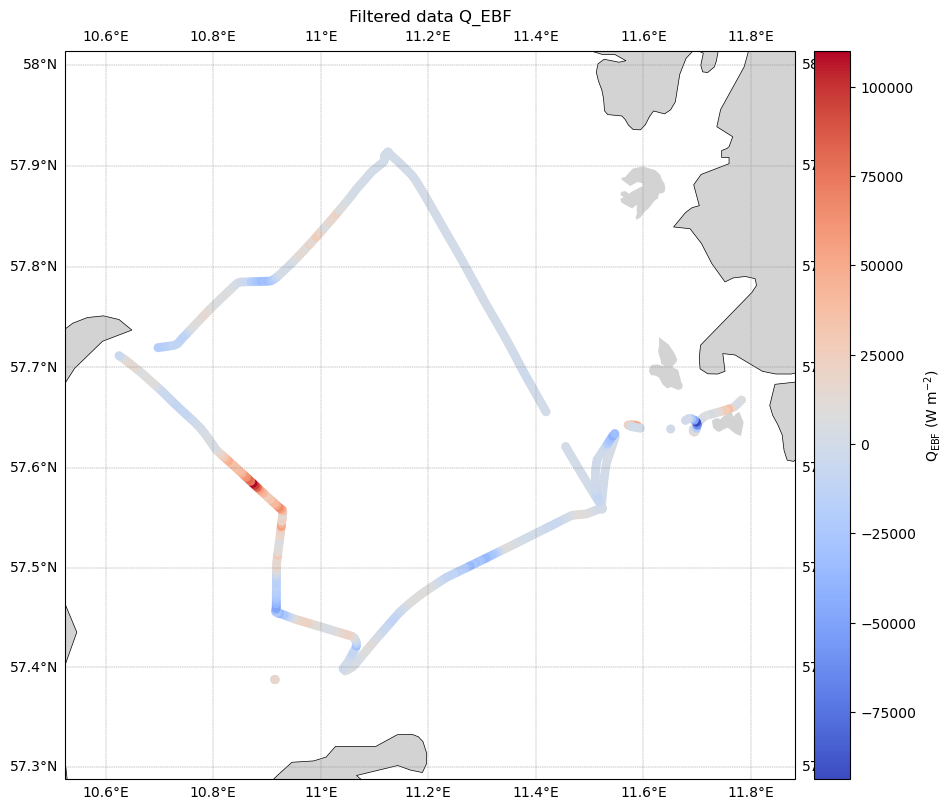

In [86]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_time_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_time_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_filtered['Longitude'], df_filtered['Latitude'],
                c=combo['Q_EBF'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Filtered data Q_EBF')
plt.tight_layout()
plt.show()


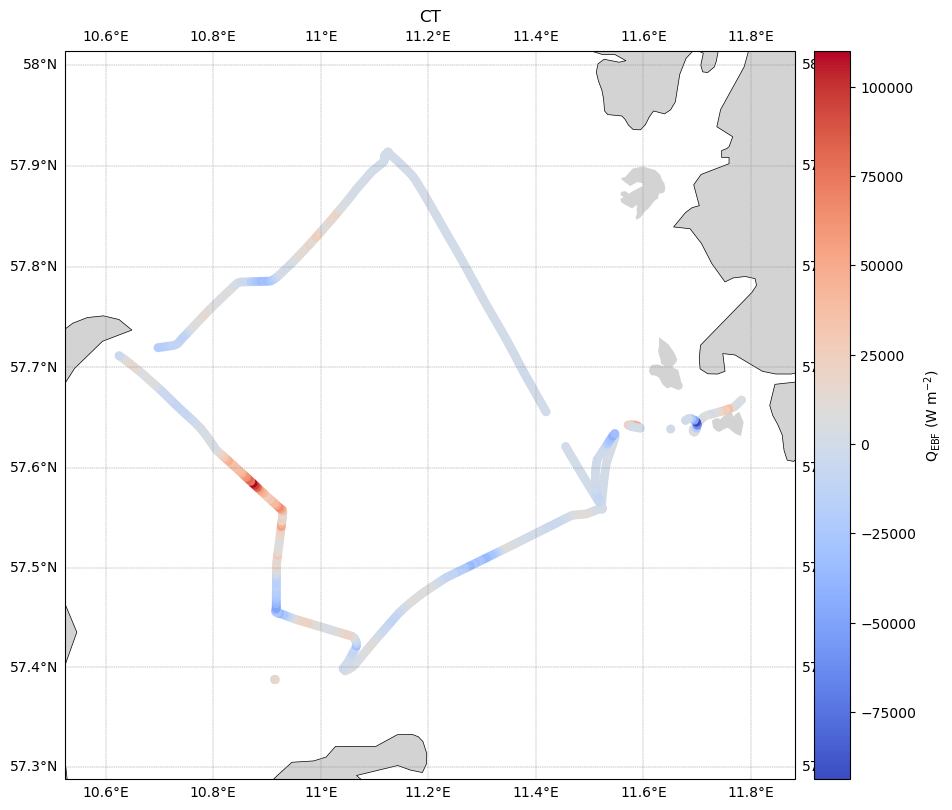

In [67]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_filtered['Latitude'].min(), df_time_filtered['Latitude'].max()
lon_min, lon_max = df_filtered['Longitude'].min(), df_time_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_filtered['Longitude'], df_time_filtered['Latitude'],
                c=Q_EBF, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('CT')
plt.tight_layout()
plt.show()
